# Iterative Solvers 2 - From FOM to GMRES

FOM is rarely used in practical applications. A problem is that it does not guarantee that the global residuals reduce from step to step. Remember that it only guarantees that the residual is orthogonal to the current search subspace.

A solution for this problem is provided by GMRES (Generalized Minimal Residuals)

## The basic idea of GMRES

GMRES, like FOM, is built oin the Arnoldi iteration. Let $V_m$ be the current Krylov basis. Remember that we want to find a correction $V_my_y$ to our initial approximation $x_0$ such that

$$
A\left(x_0 + V_my_m\right) \approx b.
$$

In the FOM we imposed the condition that $r_m\bot V_m$, that is $V_m^Tr_m = 0$. In GMRES we impose a different condition, namely we choose $y_m$ such that it minimises the residual $r_m$. Hence,

$$
y_m = \text{arg min}_{y\in\mathbb{R}^m}\left\|AV_my_m - r_0\right\|_2.
$$

We can use the Arnoldi recurrence relation $AV_m = V_mH_m + h_{m+1, m}v_{m+1}e_m^T$ to simply the above expression, namely

$$
\begin{align}
\left\|AV_my_m - r_0\right\|_2 &= \left\|{\left(V_mH_m + h_{m+1, m}v_{m+1}e_m^T\right)}y_m - r_0\right\|_2\nonumber\\
&= \left\|V_{m + 1}{\left(\begin{bmatrix}H_m \\ h_{m+1, m}e_m^T\end{bmatrix}y_m - {\left\|r_0\right\|_2}e_1\right)}\right\|_2\nonumber\\
&= \left\|{\begin{bmatrix}H_m \\ h_{m+1, m}e_m^T\end{bmatrix}y_m - \left\|r_0\right\|_2e_1}\right\|_2
\end{align}
$$

We see that we are left with a small dimensional least-squares problem that can easily be solved. A beautiful feature about GMRES is that due to the structure of $H_m$ we can just update our solution $y$ from step $m$ to step $m+1$ without solving the whole least-squares problem again.

As in the FOM we need to put in some care into proper orthogonalisation of the vectors. For the following experiments we will use the Scipy GMRES implementation, which is well tested and provides a number of useful options.

## Some experiments with GMRES

We start with a very simple setup of a matrix with random normally distributed entries.

In [2]:
import numpy as np
rand = np.random.RandomState(0)

n = 500

A = rand.randn(n, n) / np.sqrt(n)


Let us plot the eigenvalues of this matrix.

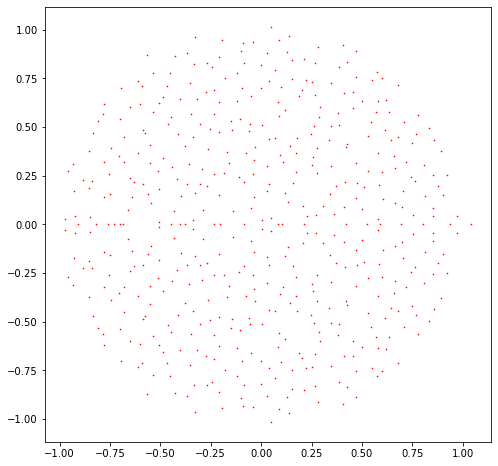

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.linalg import eigvals

eigenvalues = eigvals(A)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(np.real(eigenvalues), np.imag(eigenvalues), 'rx', markersize=1)

This matrix has nicely clustered eigenvalues which lie roughly in the unit disk.

We will now consider the matrix `Ashift` which is defined as `A + shift * np.eye(n)`, and we will plot the convergence curve of GMRES for different values of the `shift` parameter.

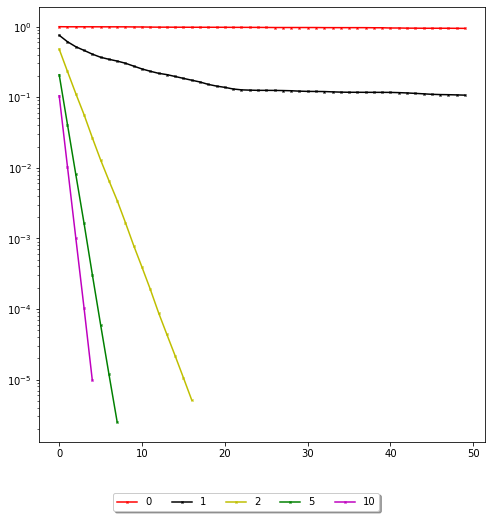

In [4]:
from scipy.sparse.linalg import gmres

shifts = [0, 1, 2, 5, 10]
colors = ['r', 'k', 'y', 'g', 'm']

b = rand.randn(n)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for index, shift in enumerate(shifts):
    Ashift = A + shift * np.eye(n)
    residuals = []
    callback = lambda res: residuals.append(res)
    x, _ = gmres(Ashift, b, restart=n, callback=callback, callback_type='pr_norm')
    if len(residuals) > 50:
        residuals = residuals[:50] # Only plot the first 50 residuals
    ax.semilogy(residuals, colors[index] + '-x', markersize=2)
    
fig.legend(loc='lower center', fancybox=True, shadow=True, ncol=len(shifts), labels=[str(shift) for shift in shifts])

    

We see that the further to the origin the cluster of eigenvalues, the slower the convergence. Convergence theorems for GMRES are only known in certain cases. A heuristical guide is that GMRES converges well if the eigenvalues are clustered together and the cluster is well separated from the origin.

## A remark on restarts

In the above code there is a `restart` parameter. One issue with GMRES is that for high number of iterations it needs a lot of memory and each step is increasingly becoming more expensive since we always have to orthogonalise against all previous vectors, so need to keep them in memory. Restarting is a strategy, where we restart the GMRES iteration with the current iterate. This is frequently used in practice and can keep the required memory low at the cost of increasing the number of required iterations.